In [1]:
%%capture
%pip install --upgrade pyarrow==10.0

In [2]:
import time, yaml
import neo4j_pq as npq
import neo4j_arrow_client as na
import pyarrow as pa
from pyarrow import parquet as pq
from time import sleep

## Managing large datasets with Apache Arrow

<p>One of the main capibilities of Apache Arrow is the ability to deal with <strong>memory-mapped files</strong>,<br>
this allows Arrow to read datasets that are bigger than the available RAM without incurring any additional memory cost.<br>

With the PyArrow ParquetDataset module we can create a dataset of memory-map parquet files, it can then be fragmented and processed in batches. <br>
    
In adition to local storage, PyArrow also supports cloud object storage such as:
<ul>
  <li>Amazon Simple Storage (S3)</li>
  <li>Google Cloud Storage (GCS)</li>
  <li>Microsoft Azure Blob Storage</li>
</ul>
</p>
 
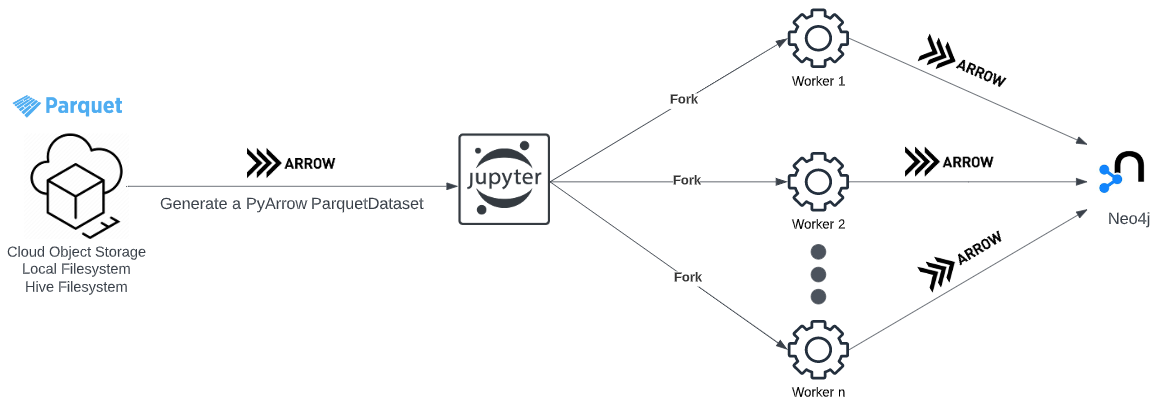

## Define your configuration
<p>The <strong>config.yaml</strong> file sets the configuration values for: 
<ul>
  <li>Neo4j Database</li>
  <li>Dataset</li>
  <li>Workers</li>
</ul>
To load a neo4j in-memory projection, make sure you add the <strong>projection</strong> config value under the neo4j section with a string value.
</p>

In [4]:
config = yaml.safe_load(open('config.yaml'))
print(yaml.dump(config, default_flow_style=False, sort_keys=False))

neo4j:
  host: 34.172.112.204
  port: 8491
  user: neo4j
  password: '!twittertest'
  tls: false
  concurrency: 50
  database: neo4j
  projection: mygraph
dataset:
  node_parquet_files_uri: gs://yan-users-export/pqdataset-projection/nodes
  relationship_parquet_files_uri: gs://yan-users-export/pqdataset-projection/relationships
worker:
  concurrency: 50
  arrow_table_size: 1000000



## Let's sample our PyArrow ParquetDataset

<p>Using the config.yml dataset uri values, we create our nodes_dataset & edges_dataset using pyarrow ParquetDataset module.<br>
One Important requirement is that your file uri values contains the <strong>nodes & relationships</strong> string.<br>
In your storage environment you can have sub-folders per node label and relationship type, pyarrow will automatically detect nested structures.
</p>

In [5]:
node_parquet_files_uri = config['dataset']['node_parquet_files_uri']
relationship_parquet_files_uri = config['dataset']['relationship_parquet_files_uri']

nodes_dataset = pq.ParquetDataset(node_parquet_files_uri, use_legacy_dataset=False)
rels_dataset = pq.ParquetDataset(relationship_parquet_files_uri, use_legacy_dataset=False)


#### Once our datasets are created we can break them into memory-mapped Fragments, this can also be done at no additional memory cost

In [6]:
node_work = [fragment for fragment in nodes_dataset.fragments]
relationship_work = [fragment for fragment in rels_dataset.fragments]
print(f"Generated {len(node_work)} node dataset fragments and {len(relationship_work)} relationship fragments")

Generated 57 node dataset fragments and 680 relationship fragments


#### You can convert a node dataset Fragment to an arrow table using the to_table() method

<p> The Neo4j server expects the arrow node records to adhere to a specific order and schema:
<ul>
  <li>The first column represents the node identifier</li>
    <ul>
        <li>Supported types: <em><strong>integer<strong></em></li><br>
    </ul>
  <li>The second column represents the node labels</li>
    <ul>
        <li>Supported types: <em><strong>string, integer or string[]</strong></em></li><br>
    </ul>    
  <li>Any aditional column is interpreted as a node property. Supported types: <em><strong>long, double, long[], double[] and float[]</strong></em></li>  
</ul>
More information can be found in: <a href="https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-nodes">https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-nodes</a>
</p>

In [7]:
print(node_work[0].to_table())

pyarrow.Table
user_id: int64
labels: string
----
user_id: [[189422349,191434991,30721733,46451499,184658736,...,52176813,247711597,1665577,260070465,37646657],[74981153,143925605,146658927,199153896,168089171,...,16073363,75195462,172915881,160381369,72519941],...,[120927735,240180088,171349796,230761015,175620361,...,143780032,278192680,243812188,80640397,135805871],[50979342,263191516,83589372,274844155,115611641,...,234283936,82664594,112792312,194442905,16907395]]
labels: [["User","User","User","User","User",...,"User","User","User","User","User"],["User","User","User","User","User",...,"User","User","User","User","User"],...,["User","User","User","User","User",...,"User","User","User","User","User"],["User","User","User","User","User",...,"User","User","User","User","User"]]


#### You can convert a relationship dataset Fragment to an arrow table using the to_table() method
<p> The Neo4j server expects the arrow relationship records to adhere to a specific order and schema:
<ul>
  <li>The first column represents the source node identifier</li>
    <ul>
        <li>Supported types: <em><strong>integer<strong></em></li><br>
    </ul>

  <li>The second column represents the target node identifier</li>
    <ul>
        <li>Supported types: <em><strong>integer<strong></em></li><br>
    </ul>
  <li>The third column represents the relationship type</li>
    <ul>
        <li>Supported types: <em><strong>integer, string<strong></em></li><br>
    </ul>
  <li>Any additional column is interpreted as a relationship property, GDS only supports relationship properties of type <em><strong>double</em></strong></li>  
</ul>
More information can be found in <a href="https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-relationships">https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-send-relationships</a>
</p>

In [8]:
print(relationship_work[0].to_table())

pyarrow.Table
source_id: int64
destination_id: int64
type: string
date: int64
----
source_id: [[41671344,49150706,170731545,34573178,172501703,...,61537575,218760649,8496182,168254740,159965707],[239298041,11541748,35069293,190916634,65833149,...,126011073,122315091,94835368,209991349,226657202],...,[280337775,79586301,61915176,207419237,191735060,...,57906563,140119738,139830841,146147804,39910661],[68302931,129362896,135341310,34960171,226064041,...,74007440,191990446,207121666,183209016,150986472]]
destination_id: [[222917419,115972111,106891591,75437770,12868702,...,73375110,162850531,68503388,157925953,115912592],[47498337,136189010,62773429,136716812,263278834,...,164358064,38436154,145626642,218758275,19843481],...,[167930700,4854424,220462834,241935181,47020485,...,167450626,87587967,99888304,57454525,54005889],[43903426,251199052,231208270,209895209,241582964,...,252378330,199948163,94509067,194580470,183852846]]
type: [["FOLLOWS","FOLLOWS","FOLLOWS","FOLLOWS","FOLLOWS",...,"F

## Ingestion Process

<p>
    <ul>
        <li>Create your <strong>Neo4jArrowClient</strong> with the defined configuration, this will allow you to orchestrate the graph database load</li>
        <li>We build work tasks for our worker pool, Each task contains the PyArrow ParquetDataset Fragment, each Fragment gets broken into RecordBatches of the size defined in our configuration</li>
    </ul>
To load a neo4j in-memory projection, make sure you add the <strong>projection</strong> config value under the neo4j section with a string value.    
</p>

In [9]:
config = yaml.safe_load(open('config.yaml'))
print(yaml.dump(config, default_flow_style=False, sort_keys=False))

neo4j:
  host: 34.172.112.204
  port: 8491
  user: neo4j
  password: '!twittertest'
  tls: false
  concurrency: 50
  database: neo4j
  projection: mygraph
dataset:
  node_parquet_files_uri: gs://yan-users-export/pqdataset-projection/nodes
  relationship_parquet_files_uri: gs://yan-users-export/pqdataset-projection/relationships
worker:
  concurrency: 50
  arrow_table_size: 1000000



In [10]:
client = na.Neo4jArrowClient(host = config['neo4j']['host'],
                             port = config['neo4j']['port'],
                             user = config['neo4j']['user'], 
                             password = config['neo4j']['password'],
                             tls = config['neo4j']['tls'], 
                             concurrency = config['neo4j']['concurrency'], 
                             database = config['neo4j']['database'],
                             projection = config['neo4j']['projection'])

print(f"Created {client}")

Created Neo4jArrowClient{neo4j@34.172.112.204:8491/neo4j}


### Let's Build the Graph Database!

Now that we have our `Neo4jArrowClient`, we can orchestrate our graph database load.

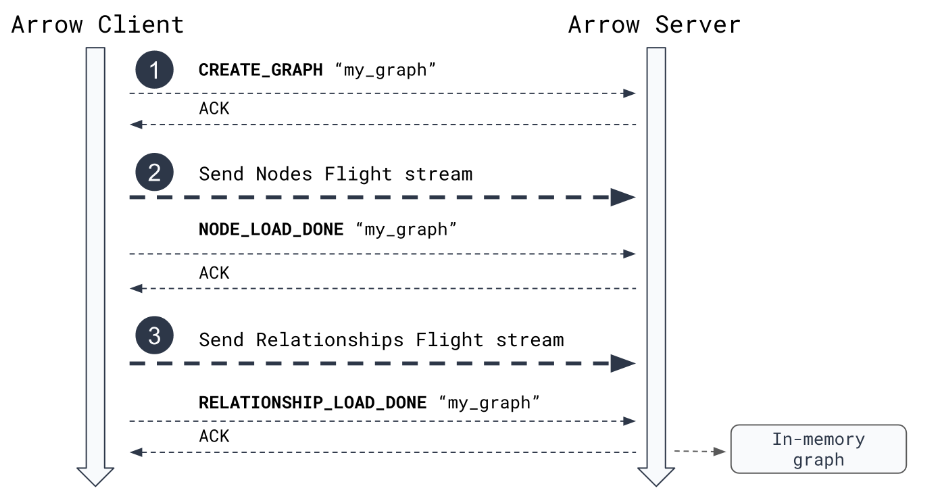

#### 1. Initializing the Import Process
<p>We send our <em><strong>CREATE_GRAPH</strong></em> signal, letting Neo4j know we are beginning our load.<br>
The action body is a JSON document containing metadata for the import process, defined in the below cell as <strong>import_config</strong>
<ul>
    <li>The <strong>name</strong> is used to identify the import process, it is also the name of the resulting in-memory graph in the graph catalog.</li>
    <li>The <strong>database_name</strong> is used to tell the server on which database the projected graph will be available.</li>
    <li>The <strong>concurrency</strong> key is optional, it is used during finalizing the in-memory graph on the server after all data has been received.</li>
</ul>    
The server acknowledges creating the import process by sending a result JSON document which contains the name of the import process.<br>
If an error occurs, e.g., if the graph already exists or if the server is not started, the client is informed accordingly.<br><br>
More information can be found in <a href="https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-initialize-import-process">https://neo4j.com/docs/graph-data-science/current/graph-project-apache-arrow/#arrow-initialize-import-process</a>
</p>

In [11]:
import_config = {
                "name": config['neo4j']['projection'],
                "database_name": config['neo4j']['database'],
                "concurrency": config['neo4j']['concurrency'],
            }

msg = client.create_projection(config=import_config)
print(f"✅ Ready to load nodes for {msg['name']}")

✅ Ready to load nodes for mygraph


#### 2a. Send our Nodes!
We can send data in parallel to speed up the ingestion process, we fan out the node
dataset fragments to numerous workers processes.

Each worker will receive a dataset fragment along with a copy of the `Neo4jArrowClient` config, <br>
each fragment gets broken into RecordBatches of the size defined in our configuration the **default is 1,000,000**
and streamed over to Neo4j using our client.

In [12]:
node_results, timing = npq.fan_out(client, 
                                   config['dataset']['node_parquet_files_uri'], 
                                   config['worker']['arrow_table_size'], 
                                   config['worker']['concurrency'])

total_nodes = sum([x["rows"] for x in node_results])
total_bytes = sum([x["bytes"] for x in node_results])

node_rate = int(total_nodes / timing)
data_rate = int(total_bytes / timing) >> 20

sleep(2)
print(f"Sent: {total_nodes:,} nodes in {round(timing, 2)}s (~{node_rate:,} nodes/s, ~{data_rate} MiB/s)")

Dataset <class 'pyarrow.parquet.core._ParquetDatasetV2'> created from: gs://yan-users-export/pqdataset-projection/nodes
Using: 🚀 Neo4jArrowClient{neo4j@34.172.112.204:8491/neo4j}
Spawning 50 workers 🧑‍🏭 to process 57 dataset fragments 📋
⚙️ Loading: [➶➶➶]
🏁 Completed in 5.13s


Sent: 280,737,646 nodes in 5.13s (~54,767,801 nodes/s, ~4211 MiB/s)


In [13]:
print("Signalling we're done loading nodes...\n")
msg = client.nodes_done()
print(f"✅ Loaded {msg['node_count']:,} nodes. Ready for edges!")

Signalling we're done loading nodes...

✅ Loaded 280,737,646 nodes. Ready for edges!


#### 3a. Send our Relationships
Time to stream the Relationships! Just like before, fan out the workload across a pool
of worker processes.

In [14]:
edge_results, timing = npq.fan_out(client, config['dataset']['relationship_parquet_files_uri'], 
                                   config['worker']['arrow_table_size'], 
                                   config['worker']['concurrency'])

total_edges = sum([x["rows"] for x in edge_results])
total_bytes = sum([x["bytes"] for x in edge_results])

edge_rate = int(total_edges / timing)
data_rate = int(total_bytes / timing) >> 20

sleep(2)
print(f"Sent: {total_edges:,} relationships in {round(timing, 2)}s (~{edge_rate:,} edges/s, ~{data_rate} MiB/s)")

# Client object goes stale after very long running ingestion, this is a workaround
client.client = None

Dataset <class 'pyarrow.parquet.core._ParquetDatasetV2'> created from: gs://yan-users-export/pqdataset-projection/relationships
Using: 🚀 Neo4jArrowClient{neo4j@34.172.112.204:8491/neo4j}
Spawning 50 workers 🧑‍🏭 to process 680 dataset fragments 📋
⚙️ Loading: [➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶➶]
🏁 Completed in 86.79s


Sent: 1,547,592,061 relationships in 86.79s (~17,830,707 edges/s, ~1804 MiB/s)


In [15]:
print("Awaiting neo4j database creation...\n")
msg = client.edges_done()

print(f"✅ Loaded {msg['relationship_count']:,} edges.")
print("😁 Happy Graphing! 🥳")

Awaiting neo4j database creation...

✅ Loaded 1,547,592,061 edges.
😁 Happy Graphing! 🥳
